Loading Files, Initializing data

In [26]:
#Goal: Given fMRI scan, predict concepts associated. 

from pybraincompare.compare.maths import calculate_correlation
from pybraincompare.compare.mrutils import get_images_df
from pybraincompare.mr.datasets import get_standard_mask
from pybraincompare.mr.transformation import *
import pandas
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import os
import cPickle as pickle
from sklearn.svm import SVC
from utils import (
   get_base, get_pwd, make_dirs
)
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
import numpy as np
from cognitiveatlas.api import get_concept
from sklearn.metrics import hamming_loss
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import tree

base = "/home/mjfang/forward-modeling-cognitive-concepts"
results = os.path.abspath("%s/results" %(base))

labels_tsv = "%s/concepts_binary_df.tsv" %results
contrast_file = "%s/filtered_contrast_images.tsv" %results
image_lookup = "%s/image_nii_lookup.pkl" %results

Y = pandas.read_csv(labels_tsv,sep="\t",index_col=0)
image_df = pandas.read_csv(contrast_file,sep="\t",index_col=0)
image_df.index = image_df.image_id

# We should standardize cognitive concepts before modeling
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# scaled = pandas.DataFrame(StandardScaler().fit_transform(X))
# scaled.columns = X.columns
# scaled.index = X.index
# X = scaled


# Dictionary to look up image files (4mm)
lookup = pickle.load(open(image_lookup,"rb"))

# Get standard mask, 4mm
standard_mask=get_standard_mask(4)

# We will save data to dictionary
result = dict()

concepts = Y.columns.tolist()

# We will go through each voxel (column) in a data frame of image data
image_paths = lookup.values()
mr = get_images_df(file_paths=image_paths,mask=standard_mask)
image_ids = [int(os.path.basename(x).split(".")[0]) for x in image_paths]
mr.index = image_ids

 
norm = pandas.DataFrame(columns=mr.columns)

# Normalize the image data by number of subjects
#V* = V/sqrt(S) 
for row in mr.iterrows():
    subid = row[0]
    number_of_subjects = image_df.loc[subid].number_of_subjects.tolist()
    norm_vector = row[1]/numpy.sqrt(number_of_subjects)
    norm.loc[subid] = norm_vector
del mr

X = norm.loc[image_ids, :].values
y = Y.loc[image_ids, concepts].values

#maybe split this for SLURM

Iterative Stratification
(http://lpis.csd.auth.gr/publications/sechidis-ecmlpkdd-2011.pdf)

In [27]:
def get_argmin_exclude_zero(num_pos_y_remaining):
    argmin = -1
    min_val = max(num_pos_y_remaining) + 1
    ties = []
    for i in range(len(num_pos_y_remaining)):
        if num_pos_y_remaining[i] <= min_val and num_pos_y_remaining[i] != 0:
            if num_pos_y_remaining[i] == min_val:
                ties.append(i)
            else:
                ties = []
                argmin = i
                min_val = num_pos_y_remaining[i]
    ties.append(argmin)
    return np.random.choice(ties)

def get_subset(c_l, c_j):
    #get max
    argmax = -1
    max_val = -1
    ties = []
    for i in range(len(c_l)):
        if c_l[i] == max_val:
            ties.append(i)
        elif c_l[i] > max_val:
            ties = []
            argmax = i
            max_val = c_l[i]
    ties.append(argmax)
    
    if len(ties) == 1:
        return ties[0]
    else:
        #go by c_j
        argmax = -1
        max_val = -1
        ties = []
        for i in range(len(c_j)):
            if c_j[i] == max_val:
                ties.append(i)
            elif c_j[i] > max_val:
                ties = []
                argmax = i
                max_val = c_j[i]
        ties.append(argmax)
        return np.random.choice(ties)
    
#k: the number of folds
def iterative_stratification(X, y, k):
    np.random.seed(1)
    num_examples = y.shape[0]
    num_labels = y.shape[1]
    D = range(num_examples)
    r = 1/float(k)
    c_j = np.empty(k) 
    c_j.fill(len(D) * r) #the number of desired examples per fold. 
    D_i = np.sum(y, axis = 0)
    c_i_j = np.outer(np.ones(k) * r, D_i) #(k, num_labels)) #breakdown the number of desired examples by label
    
    S = []
    for i in range(k):
        S.append([])

    lmins = []
    while len(D) > 0:
        D_i = np.sum(y[D, :], axis = 0)
        l = get_argmin_exclude_zero(D_i)
        if l == -1: #no labels left? (possible if one ex gets no label?)
            print len(D) , " left, assigning randomly now"
            for elem in D:
                m = np.random.choice(range(k))
                S[m].append(elem)
            break
            
        lmins.append(l)
        removedIndices = set()
        for idx in D:
            if y[idx, l] == 1:
                m = get_subset(c_i_j[:, l], c_j)
#                 print c_i_j
#                 print m
                S[m].append(idx)
                removedIndices.add(idx)
                c_i_j[m, np.where(y[idx, :] == 1)] -= 1
                c_j[m] -= 1
        for item in list(D):
            if item in removedIndices:
                D.remove(item)        
#     print lmins
#     print "labels taken into account: ", len(lmins)

    train_test_splits = []
    for i in range(k):
        train = []
        for j in range(k):
            if j != i:
                train.extend(S[j])
        train_test_splits.append((train, S[i]))
    return train_test_splits

In [28]:
def runFunction(model, is_iterative_strat=True):

    numCorrect = 0
    numBaseline = 0

    # X = norm.values # 
    # y = Y.values # example x concepts

    X = norm.loc[image_ids, :].values
    y = Y.loc[image_ids, concepts].values

    numPos = np.sum(Y.loc[image_ids, concepts].values, axis = 0) #num positive by concept
    order = np.argsort(np.array(numPos)).tolist()
    order.reverse()
    #y: #examples (93) x #concepts (92)
    pResults = []
    rResults= []
    aucResults = []

    counter = 0
    ham_loss= []
    
    fold_strat = None
    if is_iterative_strat:
        fold_strat = iterative_stratification(X, Y.loc[image_ids, concepts].values, 5)
    else:
        skf = KFold(5)
        fold_strat = skf.split(X, Y.loc[image_ids, concepts[0]].values)
    
    for train_idx, test_idx in fold_strat:#iterative_stratification(X, y[:, order[:20]], 5):
        print "split"
        y_preds = []
        y_tests = []
        y_probs = []

        for label_idx in order:

            counter += 1
            X_train = X[train_idx]
            y_train = Y.loc[image_ids, concepts[label_idx]].values[train_idx]


            X_test = X[test_idx]
            if(sum(y_train) == 0):
                #just make preds all 0 
                y_preds.append(np.zeros((len(pred), 1)))
            else:

                y_test = Y.loc[image_ids, concepts[label_idx]].values[test_idx]
        #         print y_test
                model.fit(X_train, y_train)
                pred = model.predict(X_test)
                y_preds.append(pred.reshape((len(pred), 1)))
            y_tests.append(y_test.reshape((len(pred), 1)))
        y_preds = np.hstack(y_preds)
        y_tests = np.hstack(y_tests)
        p, r = evaluate(y_preds, y_tests)
        pResults.append(p)
        rResults.append(r)

        ham_loss.append(hamming_loss(y_tests, y_preds))

    return np.vstack(pResults), np.vstack(rResults)


In [29]:
def plotResults(pResults, rResults, order):
    names = []
    precisions = []
    recalls = []
    precisionsVar= []
    recallsVar = []
    counter = 0
    
    nonZeroRecallsVar = []
    nonZeroPrecisionsVar = []
    for idx in order:
        counter += 1
        if counter == 40:
            break
        concept = concepts[idx]
        names.append(concept)
        precisions.append(np.mean(pResults[:, idx]))
        recalls.append(np.mean(rResults[:, idx]))
        precisionsVar.append(np.std(pResults[:, idx]))
        recallsVar.append(np.std(rResults[:, idx]))
        
        if np.sum(pResults[:, idx]) > 0:
            nonZeroPrecisionsVar.append(np.std(pResults[:, idx]))
            nonZeroRecallsVar.append(np.std(rResults[:, idx]))
    print "average (non-zero) precision: ", np.mean(nonZeroPrecisionsVar), " average (non-zero) recall: ", np.mean(nonZeroRecallsVar)
    # print pResults
    # print len(precisions)
    error_config = {'ecolor': '0.3'}
    bar_width = 0.35
    plt.figure(figsize=(20,10))
#     real_names = getNames(names)
#     plt.xticks(np.arange(len(precisions)) + bar_width, real_names, rotation = 'vertical')

#     print np.mean(recallsVar[np.where(recallsVar > 0)]), np.mean(np.where(precisionsVar[np.where(precisionVar > 0)]))
    plt.bar(np.arange(len(precisions)),precisions, bar_width, yerr = precisionsVar, error_kw=error_config, color = 'b', label = 'precision')
    plt.bar(np.arange(len(precisions)) + bar_width, recalls, bar_width, yerr = recallsVar, error_kw=error_config, color = 'r', label = 'recall')
    plt.show()


Naive Bayes with Iterative Stratification

split
split
split
split
split
average (non-zero) precision:  0.271934745494  average (non-zero) recall:  0.292109720075


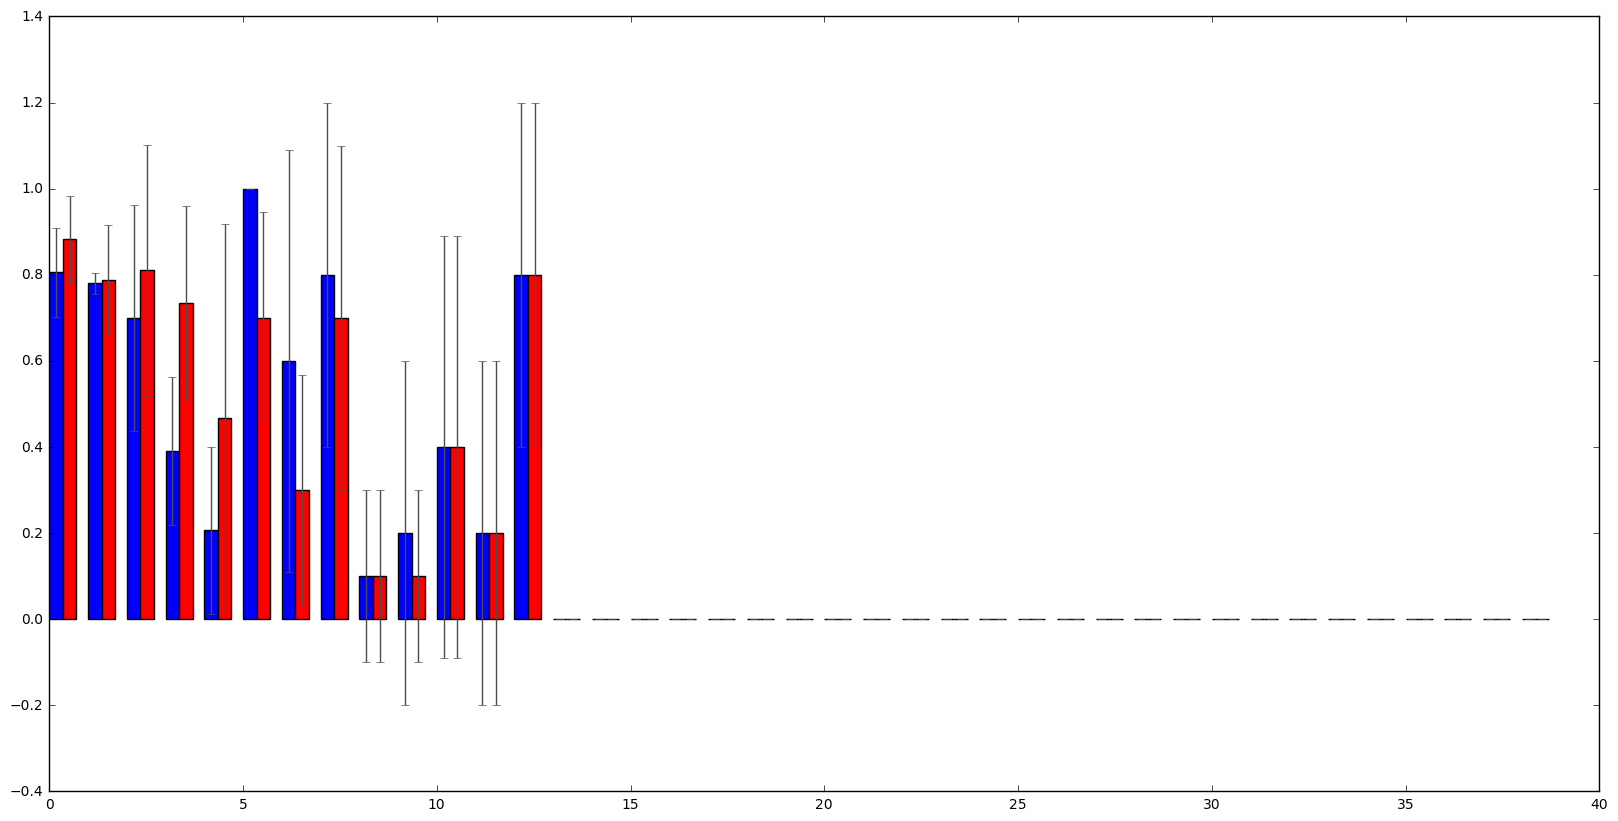

In [30]:
bayes_p_results_SI, bayes_r_results_SI = runFunction(GaussianNB(), True)
plotResults(bayes_p_results_SI, bayes_r_results_SI, range(92))

Naive Bayes with k-fold

split
split
split
split
split
average (non-zero) precision:  0.323629273691  average (non-zero) recall:  0.314137605905


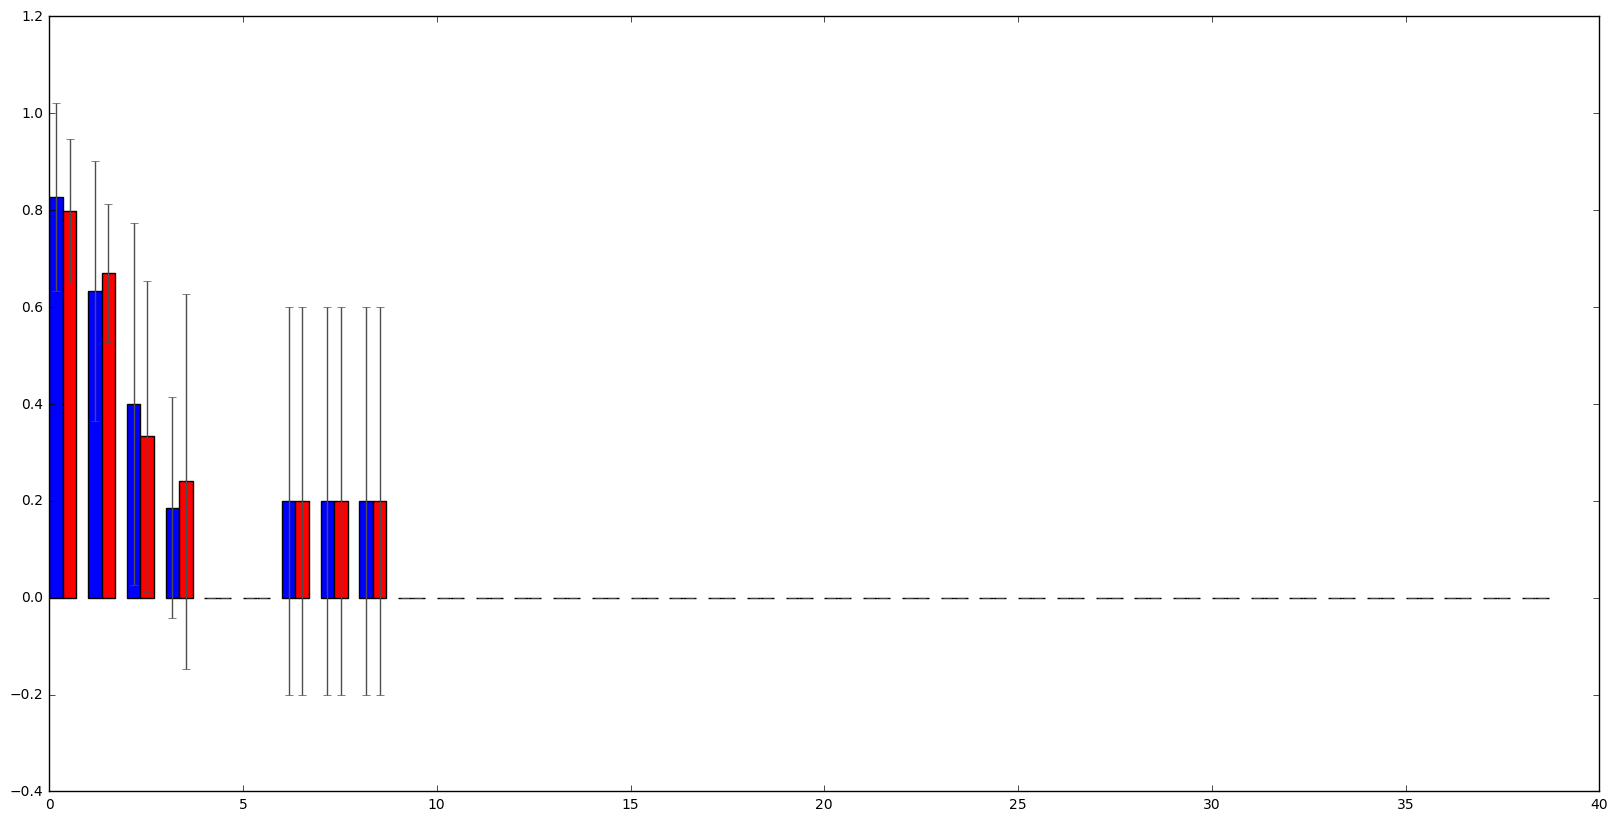

In [31]:
bayes_p_results_k, bayes_r_results_k = runFunction(GaussianNB(), False)
plotResults(bayes_p_results_k, bayes_r_results_k, range(92))

Decision Tree with iterative stratification

split
split
split
split
split
average (non-zero) precision:  0.338617778533  average (non-zero) recall:  0.360644814106


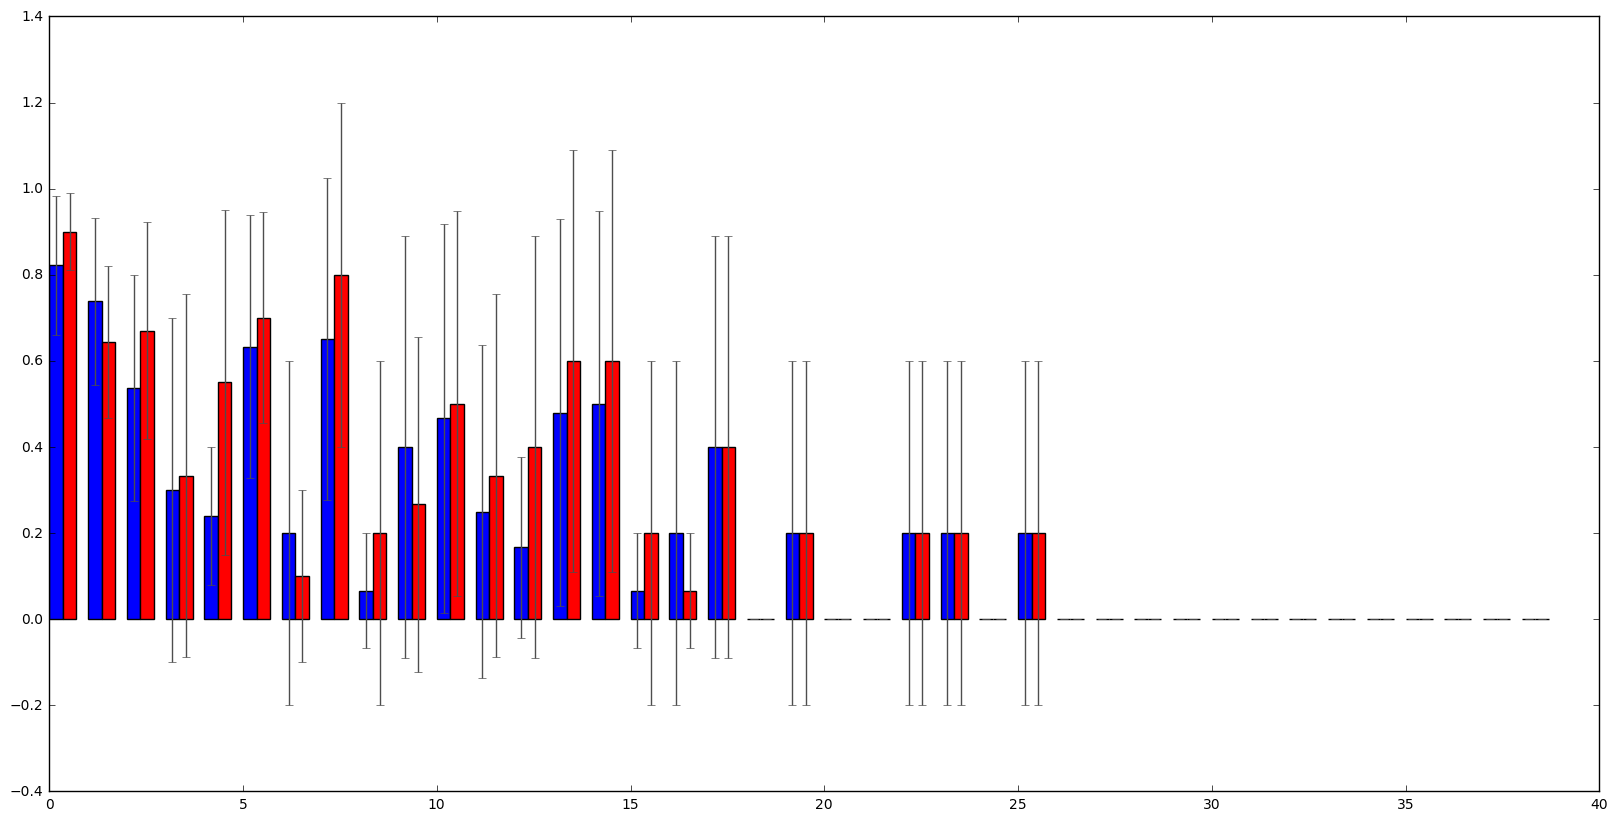

In [33]:
tree_p_results_SI, tree_r_results_SI = runFunction(tree.DecisionTreeClassifier(), True)
plotResults(tree_p_results_SI, tree_r_results_SI, range(92))

Using Partial Least Squares

(18, 92)
(19, 92)
(18, 92)
(18, 92)
(20, 92)
average (non-zero) precision:  0.281465075364  average (non-zero) recall:  0.176894949818


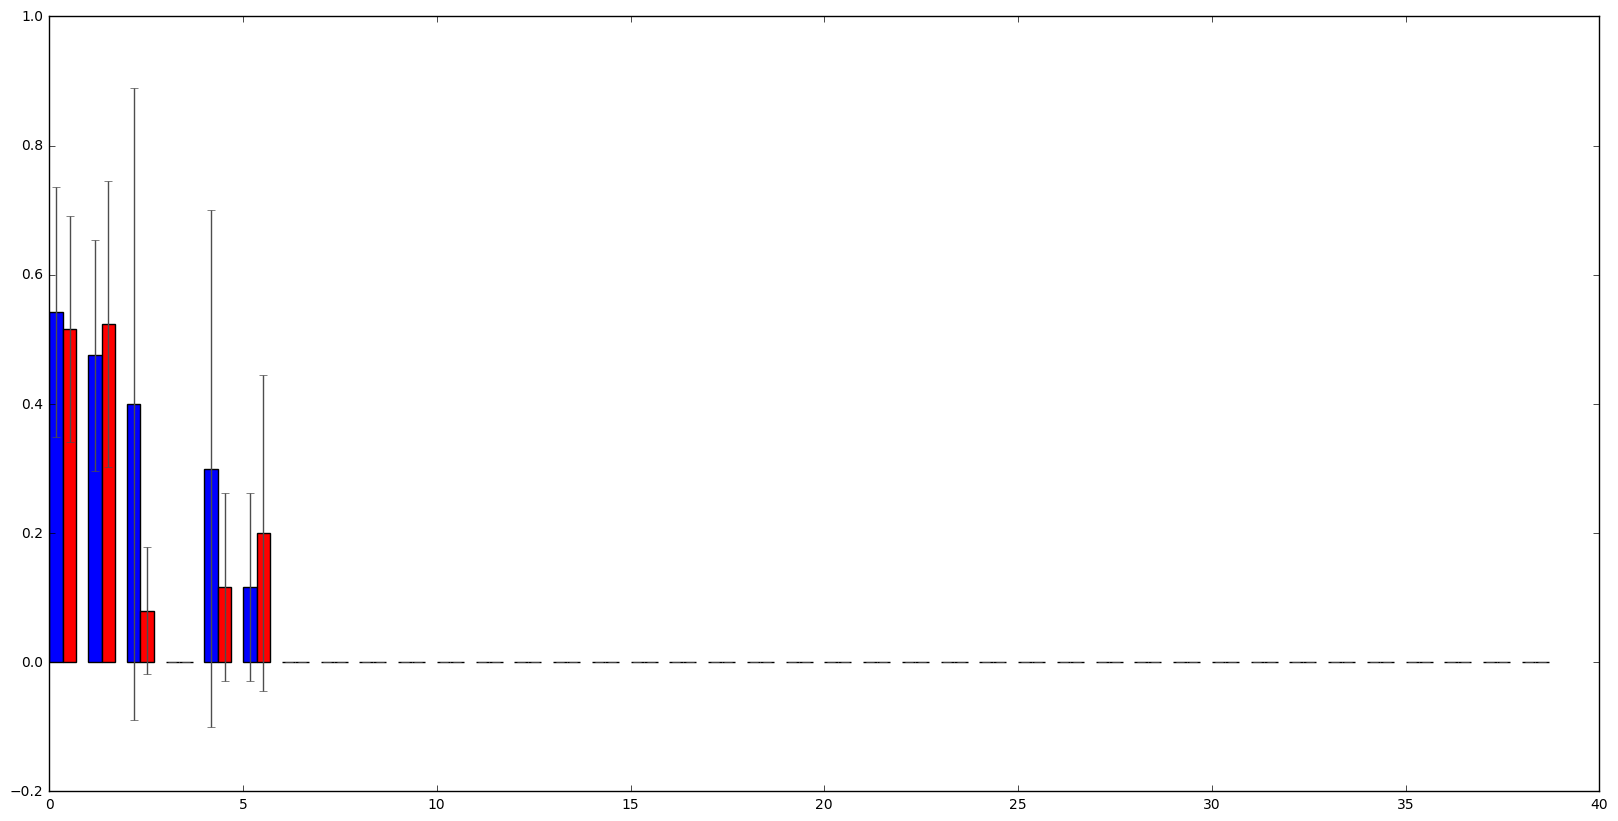

In [34]:
skf = KFold(n_splits=5)

X = norm.values # 
y = Y.values # example x concepts

# print y
pResults = []
rResults = []

numPos = np.sum(Y.loc[image_ids, concepts].values, axis = 0) #num positive by concept
order = np.argsort(np.array(numPos)).tolist()
order.reverse()

counter = 0
for train_idx, test_idx in iterative_stratification(X,y, 5):

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    plsr = PLSRegression(n_components=2, scale=True)
    plsr.fit(X_train, y_train)
    preds = plsr.predict(X_test)
    y_preds = np.where(preds > 0.5, 1, 0)

    p, r = evaluate(y_preds, y_test)
    pResults.append(p)
    rResults.append(r)
p_pls_results = np.vstack(pResults)
r_pls_results = np.vstack(rResults)
plotResults(p_pls_results, r_pls_results, order)


## Counts by label

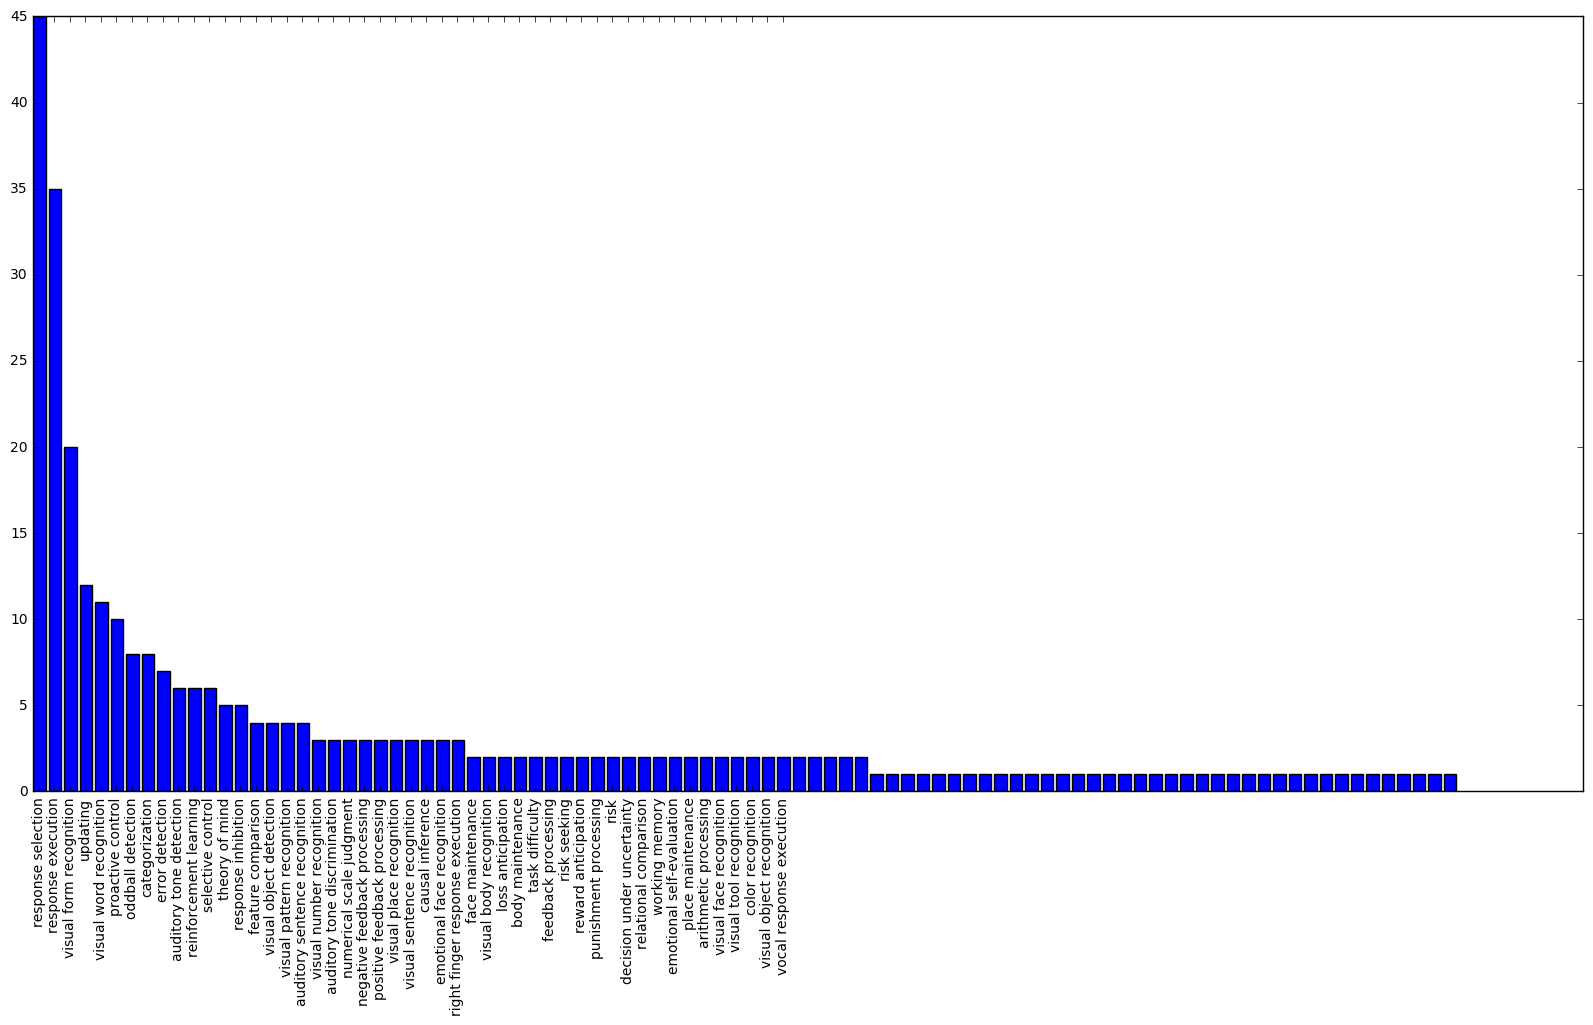

In [83]:
#concept_ids is list of ids
#returns the names of the concepts
def getNames(concept_ids):

    names = []
    for cid in concept_ids:
        names.append((get_concept(id=cid).json)[0]['name'])
    return names

totalCounts = countPos(y)

names = []
for idx in order:
    names.append(concepts[idx])

totalCount = []
counter = 0
for idx in order:
    counter += 1
#     if counter == :
#         break
    concept = concepts[idx]
    totalCount.append(totalCounts[idx])
plt.figure(figsize=(20,10))
plt.bar(np.arange(len(totalCount)), totalCount)
plt.xticks(np.arange(len(precisions)) + bar_width, real_names, rotation = 'vertical')

plt.show()